# Model

Syncing from google drive and github... for more info on this code, refer [here](https://zerowithdot.com/colab-github-workflow/)

In [1]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/filler_detection/train_data/XY_Train'       # path to your project on Drive
PROJ2= 'My Drive/filler_detection/train_data/dev_npy'

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
PROJCT_PATH2 = join(ROOT, PROJ2)
!mkdir "{PROJECT_PATH}"     # in case we haven't created it already   
!mkdir "{PROJECT_PATH2}"

GIT_PATH = "https://github.com/ybchen97/filler_detection.git"
!mkdir ./temp
!git clone "{GIT_PATH}"
!mv ./temp/* "{PROJECT_PATH}"
!rm -rf ./temp

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/filler_detection/train_data/XY_Train’: File exists
Cloning into 'filler_detection'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 3880 (delta 29), reused 64 (delta 20), pack-reused 3799
Receiving objects: 100% (3880/3880), 187.35 MiB | 37.43 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Checking 

Install packages in this local notebook specified in requirements.txt

In [2]:
!pip install -r '/content/filler_detection/requirements.txt'

     |████████████████████████████████| 81kB 12.8MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 788kB 61.2MB/s 
     |████████████████████████████████| 378kB 72.2MB/s 
     |████████████████████████████████| 12.4MB 29.6MB/s 
     |████████████████████████████████| 20.2MB 156kB/s 
     |████████████████████████████████| 358kB 58.0MB/s 
     |████████████████████████████████| 1.3MB 65.7MB/s 
     |████████████████████████████████| 921kB 29.9MB/s 
     |████████████████████████████████| 276kB 77.5MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 421.8MB 21kB/s 
     |████████████████████████████████| 450kB 53.0MB/s 
     |████████████████████████████████| 133kB 80.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a52aa847d77a34e1409318397dc17faf785ffe47d5b9ad1abd057b88edc6143e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f

In [26]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)


Importing and setting up env variables...

In [7]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
from tf_utils import *
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

# Import files for trigger-word detection model
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
from os.path import join

LOCAL_MACHINE_DIRECTORY = "./"
COLAB_DIRECTORY = "/content/drive/My Drive/filler_detection/"
REPO_DIRECTORY = COLAB_DIRECTORY # set this!

In [0]:
ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/filler_detection/train_data/'       # path to your project on Drive
COLAB_DATA_PATH = join(ROOT, PROJ)
DATA_PATH = COLAB_DATA_PATH

In [0]:
POSITIVE_DIRECTORY = "./raw_data/positive_data/"
BACKGROUND_DIRECTORY = "./raw_data/background_data/"
NEGATIVES_DIRECTORY = "./raw_data/google_dataset/"
NEGATIVES_TRUNCATED_DIRECTORY = "./raw_data/google_dataset_truncated/"
AUDIO_EXAMPLES_DIRECTORY = "./audio_examples/"
POSITIVE_EXAMPLE = "jh_1.wav"
AUDIO_EXAMPLE = "example_train.wav"

The fun begins...
## Model Loading

In [0]:
from keras.initializers import Constant

# GRADED FUNCTION: model

def create_model(input_shape, output_bias=None):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    
    # Step 2: First GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=0.8)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = Constant(value=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

Sanity check for `Tx`, `n_freq`, `Ty`. 

1. Input into model `Tx` and `n_freq`
2. Call `model.summary()`
3. `Tx` of **sample** and variable = `input_7.shape[1]` (ie column 2, row 1, second element of array)
4. `Ty` = `input_7.shape[1]` (ie column 2, row 2, second element of array)

In [0]:
Tx = 5490 # The number of time steps input to the model from the spectrogram
n_freq = 129 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1369 # The number of time steps in the output of our model

Setting correct initial bias to account for imbalanced dataset. Read more [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).

In [112]:
initial_bias = np.log([1/10])
initial_bias

array([-2.30258509])

### Load Pre-trained Model

In [123]:
model = load_model(REPO_DIRECTORY + "/new_trained_model.h5") 
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1369, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1369, 128)         0   

### Create New Model (if not pre-trained)

In [141]:
model = create_model(input_shape = (Tx, n_freq), output_bias = None)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 5490, 129)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_28 (Batc (None, 1369, 196)         784       
_________________________________________________________________
activation_10 (Activation)   (None, 1369, 196)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 1369, 196)         0         
_________________________________________________________________
gru_19 (GRU)                 (None, 1369, 128)         124800    
_________________________________________________________________
dropout_38 (Dropout)         (None, 1369, 128)         0   

## Model Training

In [0]:
# Function to fit and further train the model. Returns history (check documentation of `model.fit` for more details).
def model_train(model, X, Y, X_dev, Y_dev):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model.fit(X, Y, batch_size=5, epochs=1, validation_data=(X_dev, Y_dev))

In [196]:
X = np.load(DATA_PATH + "XY_Train/X_mini.npy")
Y = np.load(DATA_PATH + "XY_Train/Y_mini.npy")
print("X: {} Y: {}".format(X.shape, Y.shape))
X_dev = np.load(DATA_PATH + "XY_dev_synthesised/X_dev.npy")
Y_dev = np.load(DATA_PATH + "XY_dev_synthesised/Y_dev.npy")
print("X: {} Y: {}".format(X_dev.shape, Y_dev.shape))

X: (100, 5490, 129) Y: (100, 1369, 1)
X: (50, 5490, 129) Y: (50, 1369, 1)


In [142]:
model_train(model, X, Y, X_dev, Y_dev)

Epoch 1/1
100/100 [==============================] - 75s 751ms/step - loss: 1.4036


### Checkpoint the initial weights
To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [0]:
model.save_weights(REPO_DIRECTORY + "initial_weights")

## Confirming that the bias fix helps


In [197]:
zero_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = None)
zero_bias_history = model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 86s 858ms/step - loss: 1.2918 - val_loss: 0.6784


In [200]:
careful_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = initial_bias)
careful_bias_history = model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 106s 1s/step - loss: 1.2345 - val_loss: 0.6673


In [0]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

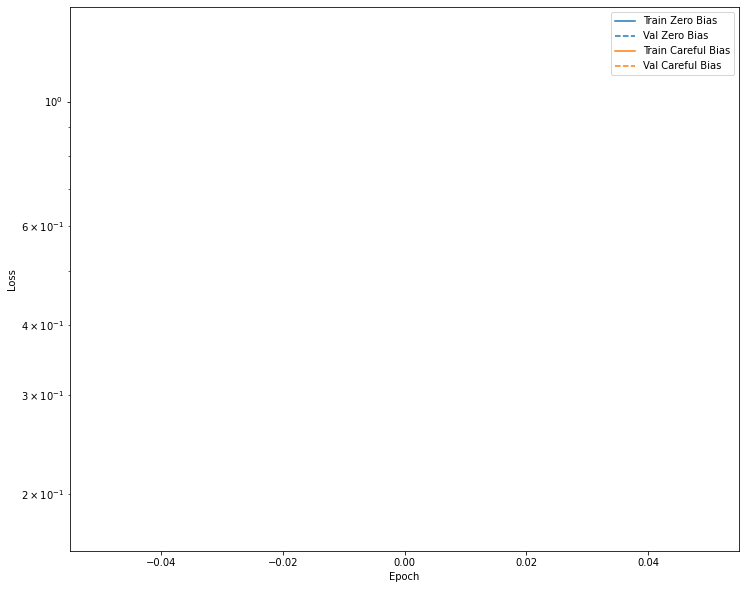

In [181]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Model Evaluation
via accuracy, precision, recall, f-score

In [201]:
X_test = np.load(DATA_PATH + "XY_test/X_test.npy")
Y_test = np.load(DATA_PATH + "XY_test/Y_test.npy")
print("X: {} Y: {}".format(X_test.shape, Y_test.shape))

X: (50, 5490, 129) Y: (50, 1369, 1)


In [188]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# Evaluates the model on the test sets based on accuracy, precision, recall, and f1 score.
def evaluate_model(model, X_test, Y_test):
    # predict probabilities for dev set
    Y_predict = model.predict(X_test, verbose=0)
    # Applying sigmoid onto prediction of probabilities in order to use f-score
    Y_predict = np.where(Y_predict > 0.5, 1, 0)

    # flatten array in order to use fscore
    Y_test_flattened = Y_test.flatten()
    Y_predict_flattened = Y_predict.flatten()

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Y_test_flattened, Y_predict_flattened)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(Y_test_flattened, Y_predict_flattened)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(Y_test_flattened, Y_predict_flattened)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Y_test_flattened, Y_predict_flattened)
    print('F1 score: %f' % f1)

Accuracy: 0.952126
Precision: 0.018541
Recall: 0.006005
F1 score: 0.009072


[OPTIONAL] Showing prediction for a particular example...

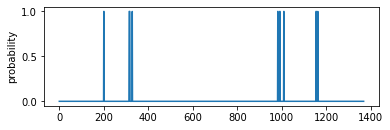

In [130]:
Y_predict = model.predict(X_test, verbose=0)

plt.subplot(2, 1, 2)
plt.plot(Y_predict[24,:,0])
plt.ylabel('probability')
plt.show()

## Saving the model

In [0]:
model.save(REPO_DIRECTORY + "new_trained_model.h5")

[Can delete the code below since `model.evaluate` is redundant now; it does not use metrics we want (ie f score)]

In [0]:
# For colab
# Function to test the model on new data
def model_test(model, X_dev, Y_dev):
    loss, acc = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

In [0]:
model_test(model, X_dev, Y_dev)

50/50 [==============================] - 8s 164ms/step
Dev set accuracy =  0.9633309245109558


In [0]:
X_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11X.npy")
Y_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11Y.npy")
print("X: {} Y: {}".format(X_11.shape, Y_11.shape))

X_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12X.npy")
Y_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12Y.npy")
print("X: {} Y: {}".format(X_12.shape, Y_12.shape))

X_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13X.npy")
Y_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13Y.npy")
print("X: {} Y: {}".format(X_13.shape, Y_13.shape))

X_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14X.npy")
Y_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14Y.npy")
print("X: {} Y: {}".format(X_14.shape, Y_14.shape))








In [0]:
model_test(model, X_11, Y_11)
model_test(model, X_12, Y_12)
model_test(model, X_13, Y_13)
model_test(model, X_14, Y_14)

In [0]:
list_of_dev_ids = [11,12,13,14,20,21,22,23,24,30,31,32,33,34,35,36,37,38,39,310,40,41,42,43,44]
for id in list_of_dev_ids:
    X_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "X.npy")

    Y_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "Y.npy")
    print(("X" + str(id) + ": {} Y" + str(id) + ": {}").format(X_id.shape, Y_id.shape))
    model_test(model, X_id, Y_id)

model_test(model, X_11, Y_11)


In [0]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    print("PREPROCESSING...")
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 123000
    segment = segment.set_channels(1)
    segment = segment.set_frame_rate(123000)
    # Export as wav
    segment.export(filename, format='wav')

In [0]:
def detect_triggerword(filename):
    """
    Function to take filename and generate a prediction vector.
    
    Argument:
    filename -- Audio file to run prediction on
    
    Returns:
    predictions -- Prediction vector with probabilities
    """
    
    sample_rate, samples = wavfile.read(filename)
    _, _, x = signal.spectrogram(samples, sample_rate)
    print(x.shape)
    
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    
    predictions = model.predict(x)
    return predictions

In [0]:
def count_filler_word(filename, threshold):
    """
    Function to count the number of times trigger word spoken in audio.
    
    Arguments:
    filename -- Audio file to run prediction on
    threshold -- Probability above which trigger word considered present
    """

    preprocess_audio(filename)
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(CHIME_FILE)
    predictions = detect_triggerword(filename)
    Ty = predictions.shape[1]
    
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [0]:
count_filler_word('./Test_2.wav', 0.4)

PREPROCESSING...
(129, 5490)
